# Predicting the NBA Draft

### By Isaac Butz, Zongxia Li, and Laksh Sekhri

---


Welcome to our tutorial! In this project, the goal is to look at what factors are the most important for NBA draft picks. First, a little bit about the NBA. The National Basketball Association, or NBA, is the highest level professional basketball league in the world. It is composed of 30 teams that play 82 games each, before a playoff bracket is set. The most common way for players to enter the league (After 2006, read more about the rule change [here](https://en.wikipedia.org/wiki/Eligibility_for_the_NBA_draft)) is to be drafted in the NBA draft. The draft consists of 2 rounds, with each team getting 1 pick per round, for a total of 60 picks. 

The end goal of this project is to try and predict the [2021 NBA draft](https://en.wikipedia.org/wiki/2021_NBA_draft) that will take place on July 29th. Finding out the position of draft picks would be useful for those in the sports industry. A team would be able to predict what players other teams will select, see if players are over/under-rated, or possibly help set sports betting odds. However to start predicting the draft, we must look at past drafts to see what are the most important factors for an NBA draft pick. The project will be broken up into 3 sections:

1. Data Wrangling
2. Analysis of Previous Drafts
3. Predictions of 2021 Draft

Over the course of this guide, we hope the reader is able to understand how and why data analysis is done, and would be able to follow similar steps to do some data science on other topics!

## Part 0: Setup

The following imports and libraries will be used

In [1]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
!pip3 install lxml

## Part 1: Data Wrangling

Perhaps the most important part is to get the data. This first dataset needed is a collection of past NBA draft picks college stats. This is what we will do analysis on, and train our machine learning model on. We found the website [barttorvik.com](https://www.barttorvik.com/playerstat.php?link=y&year=2022&start=20211101&end=20220501) that contains data on players basketball stats over the years. Secondly, a dataset is needed for the current NBA draft class. With this data, we can feed that into our model and get predictions of the draft order.

### Note to group

The data on barttorvik is a table generated using javascript. I have absolutely no idea how to scrape data in this way. To get the data, what I did was manually copy and paste the table into a blank csv file, and then pandas thankfully could interperet it decently enough. I still need to format the df. But if either of you know a better way to import the data, please do it that way/tell me and I can fix it, because copy/pasting is definitely not the best.

### Step a: Previous NBA drafts

Unfortunately, the data is generated using javascript and we were unable to parse it, so it was done manually. Here are the steps. From [here](https://www.barttorvik.com/playerstat.php?link=y&year=2022&start=20211101&end=20220501), under the top drop down menu 'all' was selected to get all time. Next, scrolling down the left side, Min%, O-Reb%, D-Reb%, Ast%, Blk%, Stl%, FTR, 2PM, 3PM, and drafted were selected to be shown. Drafted was also set to "<=" and "60", since there are 60 picks in the NBA draft. After that, "name" was clicked twice so the players were sorted by name. Then, the "Show 100 more" option was repeatedly selected, until the full 1302 element table was shown. Lastly, the entire table was selected using a cursor, and copy/pasted into a blank csv file that was read into `pandas`.

The better approach would be to use a library such a `selenium`, however we had difficulties figuring this out.

In [2]:
# Start by reading in from the csv we manually created
pastPicks_df = pd.read_csv('past_college_players.csv', '\t')
pastPicks_df.head()

,,,,RK,PICK,PLAYER,TEAM,CONF,MIN%,OR,DR,AST,BLK,STL,FTR,2P,3P,YEAR
1,46,Fr,7-0,A.J. Hammons (13),Purdue,B10,57.4,11.6,17.3,6.2,8.7,0.9,41.0,140-283,0.495,0-0,0.000,2013
2,46,So,7-0,A.J. Hammons (14),Purdue,B10,59.6,10.1,22.8,4.2,13.2,0.9,62.2,114-220,0.518,0-5,0.000,2014
3,46,Jr,7-0,A.J. Hammons (15),Purdue,B10,60.1,12.2,19.7,9.1,12.3,1.3,46.7,157-284,0.553,0-7,0.000,2015
4,46,Sr,7-0,A.J. Hammons (16),Purdue,B10,57.5,11.5,24.8,10.5,10.4,0.7,37.8,193-325,0.594,6-11,0.545,2016
5,52,Jr,6-2,A.J. Price (08),Connecticut,BE,79.7,2.8,8.1,36.1,0.3,2.3,38.8,108-225,0.480,52-141,0.369,2008


The data is super messey. We want to fix it and have the following columns:

- 'pick': What pick of the draft they were
- 'class': Their college class
- 'player': The player's name
- 'minutes_per': Percentage of the game played
- 'off_reb_per': [ORB%](https://www.basketball-reference.com/about/glossary.html#orb)
- 'def_reb_per': [DRB%](https://www.basketball-reference.com/about/glossary.html#drb)
- 'assist_per': [AST%](https://www.basketball-reference.com/about/glossary.html#ast)
- 'block_per': [BLK%](https://www.basketball-reference.com/about/glossary.html#blk)
- 'steal_per': [STL%](https://www.basketball-reference.com/about/glossary.html#stl)
- 'free_throw_per': [FT%](https://www.basketball-reference.com/about/glossary.html#ft)
- 'two_point_per': [2P%](https://www.basketball-reference.com/about/glossary.html#fg2)
- 'three_point_per': [3P%](https://www.basketball-reference.com/about/glossary.html#fg3)

The last 8 are hyperlinks to a gloassary by [basketball-reference.com](https://www.basketball-reference.com/about/glossary.html) that further explains what these columns mean.

In [3]:
# Create a 2d array that has 12 arrays for our 12 categories
data = [[], [], [], [], [], [], [], [], [], [], [], []]
for i, r in pastPicks_df.iterrows():
    data[0].append(i[1])
    data[1].append(i[2])
    data[2].append(r['RK'][slice(0, len(r['RK']) - 5)])
    data[3].append(r['TEAM'])
    data[4].append(r['CONF'])
    data[5].append(r['MIN%'])
    data[6].append(r['OR'])
    data[7].append(r['DR'])
    data[8].append(r['AST'])
    data[9].append(r['BLK'])
    data[10].append(r['FTR'])
    data[11].append(r['3P'])

headers = ['pick', 'class', 'player', 'minutes_per', 'off_reb_per',
           'def_reb_per', 'assist_per', 'block_per', 'steal_per', 'free_throw_per',
           'two_point_per', 'three_point_per']

# pandas reads in row wise, so I use T to take the transpose
pastPicks_df = pd.DataFrame(np.array(data).T, columns=headers)

# The last thing to do is only take a players final year in the NCAA. 
# Thankfully, the way the data is formatted all I have to do is get last occurance of each player
pastPicks_df = pastPicks_df.drop_duplicates(subset='player', keep='last', ignore_index=True)

# Lastly, I want to make sure we have our columns as numeric data
for c in pastPicks_df.columns:
    if c != 'class' and c != 'player':
        pastPicks_df[c] = pd.to_numeric(pastPicks_df[c])

# Push it to csv for later use as well
pastPicks_df.to_csv('cleaned_train.csv')

pastPicks_df.head()

,pick,class,player,minutes_per,off_reb_per,def_reb_per,assist_per,block_per,steal_per,free_throw_per,two_point_per,three_point_per
0,46,Sr,A.J. Hammons,57.5,11.5,24.8,10.5,10.4,0.7,37.8,0.594,0.545
1,52,Sr,A.J. Price,73.0,2.1,9.2,28.5,0.0,1.2,30.3,0.422,0.398
2,4,Fr,Aaron Gordon,77.1,10.4,19.3,13.0,3.4,1.8,47.1,0.513,0.356
3,23,Jr,Aaron Holiday,92.1,1.6,8.7,29.9,0.7,1.9,41.7,0.486,0.429
4,14,Fr,Aaron Nesmith,72.2,4.2,17.3,10.8,2.1,1.4,27.5,0.474,0.337


### Step b: This year's draft

Unfortunately we will not be able to predict everyone in the draft. This is because the deadline for players to announce for the NBA draft is May 30th, and this project is due May 17th. However, most players who will be picked higher up in the rankings declare earlier for the draft, so we can use these early declarations for predictions. [This website](https://ca.nba.com/news/2021-nba-draft-ncaa-players-that-have-declared-for-the-2021-nba-draft-e/hphzsl6bo6dh16t9tpee5628y) contains a nice table of all the players who have declared early thus far. 

Next, we use this list of names as a cross reference for the 2021 season stats, getting the 2021 season players stats from barttorvik.com again. Like before, this data is created using javascript, so here are the steps for how we manually got the data. First, go to [barttorvik player stats](https://www.barttorvik.com/playerstat.php?year=2021). Make sure the year is 2021. Next, select Min%, O-Reb%, D-Reb%, Ast%, Blk%, Stl%, FTR, 2PM, and 3PM. And once again, show 100 more was selected repeatedly until all 2125 players were visible. Lastly, this was copy/pasted into a csv file, which is read in and processed.

In [4]:
# HTML Scraping the list of early draft commits using requests, BeautifulSoup, and pandas
r = requests.get("https://ca.nba.com/news/2021-nba-draft-ncaa-players-that-have-declared-for-the-2021-nba-draft-e/hphzsl6bo6dh16t9tpee5628y")
soup = BeautifulSoup(r.content, 'lxml')

# Find the table in the html, thankfully only one
html_table = soup.find("table")
earlycomm_df = pd.read_html(str(html_table), header=0)[0]
earlycomm_df.head()

,Player,Position,Year,School
0,Ochai Agbaji,SG,Jr.,Kansas
1,James Akinjo,PG,Jr.,Arizona
2,Keve Aluma,PF,R-Jr.,Virginia Tech
3,Jose Alvarado,PG,Sr.,Georgia Tech
4,Avery Anderson III,PG,So.,Oklahoma State


In [5]:
# Moving onto the 2021 season data, we read in our player data from the csv 
stats2021_df = pd.read_csv('2021season.csv', '\t')
stats2021_df.head()

,,,,RK,PLAYER,TEAM,CONF,MIN%,OR,DR,AST,BLK,STL,FTR,2P,3P
1,Jr,6-5,A.J. Caldwell,Chattanooga,SC,80.2,1.6,14.9,13.7,1.3,2.1,9.2,15-41,0.366,36-90,0.400
2,Sr,6-5,A.J. Lawson,McNeese St.,Slnd,73.3,5.3,14.9,33.9,0.4,1.4,42.3,58-122,0.475,11-34,0.324
3,Jr,6-5,A.J. Oliver II,Old Dominion,CUSA,66.9,2.5,8.9,7.3,0.8,1.1,19.2,36-65,0.554,32-102,0.314
4,So,6-2,A.J. Plitzuweit,South Dakota,Sum,75.6,2.4,11.6,23.4,0.3,1.5,38.3,76-165,0.461,52-117,0.444
5,Jr,6-6,A.J. Reeves,Providence,BE,77.2,2.3,10.6,10.3,0.3,1.9,23.2,31-74,0.419,48-150,0.320


To clean us this `DataFrame`, I am going to follow almost exactly the same steps as I did in step a. The columns will be the exact same, except there won't be a 'pick' column.

In [6]:
# Create a 2d array that has 11 arrays for our 11 categories
data = [[], [], [], [], [], [], [], [], [], [], []]
for i, r in stats2021_df.iterrows():
    data[0].append(i[1])
    data[1].append(i[3])
    data[2].append(r['TEAM'])
    data[3].append(r['CONF'])
    data[4].append(r['MIN%'])
    data[5].append(r['OR'])
    data[6].append(r['DR'])
    data[7].append(r['AST'])
    data[8].append(r['BLK'])
    data[9].append(r['FTR'])
    data[10].append(r['3P'])

# pandas reads in row wise, so I use T to take the transpose
temp = pd.DataFrame(np.array(data).T, columns=headers[1:])

# Cross reference to get players who have declared for the draft
temp = temp.where(temp['player'].isin(earlycomm_df['Player']))
stats2021_df = temp.dropna(how='all').reset_index(drop=True)

# push to csv for later
stats2021_df.to_csv('cleaned2021.csv')

stats2021_df.head()

,class,player,minutes_per,off_reb_per,def_reb_per,assist_per,block_per,steal_per,free_throw_per,two_point_per,three_point_per
0,Jr,Aaron Henry,80.9,4.8,14.6,25.2,4.1,2.4,28.9,0.493,0.29600000000000004
1,Jr,Aaron Wiggins,83.3,4.5,15.9,17.2,2.0,2.1,20.3,0.515,0.34600000000000003
2,Jr,Alan Griffin,72.8,6.3,15.2,12.2,6.6,2.3,19.0,0.514,0.354
3,Sr,Alfonso Plummer,69.8,1.3,7.9,7.5,0.2,1.5,12.1,0.526,0.38299999999999995
4,So,Armando Bacot,56.6,14.5,22.3,7.3,4.3,1.6,58.3,0.631,0.0


## Part 2

Now that all the data has been collected, the data analysis can begin. The goal is to look for trends between high draft picks and player's stats. We will start off with plotting possibly the most simple breakdown, age. At the same time, we can plot draft pick over minutes played to see the importance fo that.

In [7]:
# Set up for this plot
classes = ['Fr', 'So', 'Jr', 'Sr']
colors = ['red', 'yellow', 'blue', 'green']
by_age = []

# Use a list comprehension 4 times
for c in classes:
    # Get 4 lists, each one contains draft picks from that class
    by_age.append([r['pick'] for i, r in pastPicks_df.iterrows() if r['class'] == c])

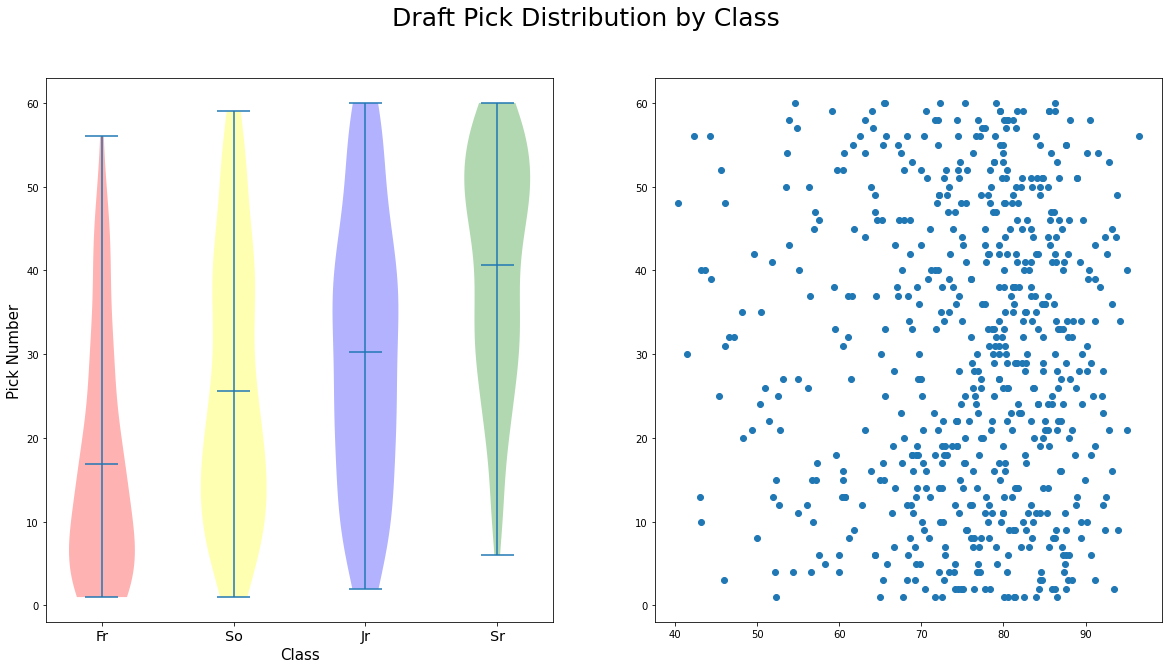

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))

# Plotting by class
parts1 = ax1.violinplot(by_age, range(len(classes)), showmeans=True)

# Plotting Pick over minutes played. Cast to float
parts2 = ax2.scatter(pastPicks_df['minutes_per'], pastPicks_df['pick'])

# Setting plot colors
for i, pc in enumerate(parts1['bodies']):
    pc.set_facecolor(colors[i])

# Titles/labels
plt.suptitle("Draft Pick Distribution by Class", fontsize=25)
ax1.set_xlabel('Class', fontsize=15)
ax1.set_ylabel('Pick Number', fontsize=15)

plt.sca(ax1)
plt.xticks(range(len(classes)), classes, fontsize='x-large')

plt.show()

## Part 3

Next we can try to train a model to predict the 2021 NBA draft. We have shown what parameters seem to be the most important, so we can train the model to look at those.......
